# Lecture 11 - Gaussian Process Regression

## Objectives

+ to do regression using a GP
+ to find the hyperparameters of the GP by maximizing the (marginal) likelihood
+ to use GP regression for uncertainty propagation

## Readings

+ Please read [this](http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/pdfs/pdf2903.pdf) OR watch [this video lecture](http://videolectures.net/mlss03_rasmussen_gp/?q=MLSS).

+ [Section 5.4 in GP for ML textbook](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf).

+ See slides for theory.

## Example

The purpose of this example is to demonstrate Gaussian process regression. To motivate the need let us introduce a toy uncertainty quantification example:

> We have developed an "amazing code" that models an extremely important physical phenomenon. The code works with a single input paramete $x$ and responds with a single value $y=f(x)$. A physicist, who is an expert in the field, tells us that $x$ must be somewhere between 0 and 1. Therefore, we treat it as uncertain and we assign to it a uniform probability density:
$$
p(x) = \mathcal{U}(x|0,1).
$$
Our engineers tell us that it is vitally important to learn about the average behavior of $y$. Furthermore, they believe that a value of $y$ greater than $1.2$ signifies a catastrophic failure. Therefore, we wish to compute:
1. the variance of $y$:
$$
v_y = \mathbb{V}[f(x)] = \int\left(f(x) - \mathbb{E}[f(x)]\right)^2p(x)dx,
$$
2. and the probability of failure:
$$
p_{\mbox{fail}} = P[y > 1.2] = \int\mathcal{X}_{[1.2,+\infty)}(f(x))p(x)dx,
$$
where $\mathcal{X}_A$ is the characteristic function of the set A, i.e., $\mathcal{X}_A(x) = 1$ if $x\in A$ and $\mathcal{X}_A(x) = 0$ otherwise.
Unfortunately, our boss is not very happy with our performance. He is going to shut down the project unless we have an answer in ten days. However, a single simulation takes a day... We can only do 10 simulations! What do we do?

Here is the "amazing code"...

In [1]:
import numpy as np
# Here is an amazing code:
solver = lambda x: -np.cos(np.pi * x) + np.sin(4. * np.pi * x)
# It accepts just one input parameter that varies between 0 and 1.

### Part 1 - Learning About GP Regression
This demonstrates how do do Gaussian process regression.


Name : GP regression
Objective : 13.154203681982867
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        
> writing model to file: surrogate.pcl


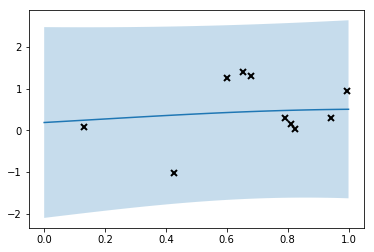

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn
import pickle as pickle
import GPy

# Ensure reproducibility
np.random.seed(1345678)

# Select the number of simulations you want to perform:
num_sim = 10

# Generate the input data (needs to be column matrix)
X = np.random.rand(num_sim, 1)

# Evaluate our amazing code at these points:
Y = solver(X)

# Pick a covariance function
k = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

# Construct the GP regression model
m = GPy.models.GPRegression(X, Y, k)

# That's it. Print some details about the model:
print (m)

# Now we would like to make some predictions
# Namely, we wish to predict at this dense set of points:
X_p = np.linspace(0, 1., 100)[:, None]

# We can make predictions as follows
Y_p, V_p = m.predict(X_p) # Y_p = mean prediction, V_p = predictive variance
# Here is the standard deviation:
S_p = np.sqrt(V_p)
# Lower predictive bound
Y_l = Y_p - 2. * S_p
# Upper predictive bound
Y_u = Y_p + 2. * S_p

# Plot the results
fig, ax = plt.subplots()
ax.plot(X_p, Y_p, label='Predictive mean')
ax.fill_between(X_p.flatten(), Y_l.flatten(), Y_u.flatten(), alpha=0.25, label='Predictive error bars')
ax.plot(X, Y, 'kx', markeredgewidth=2, label='Observed data')

# Write the model to a file 
print ('> writing model to file: surrogate.pcl')
#with open('surrogate.pcl', 'wb') as fd:
#    pickle.dump(m, fd)

#### Questions
1. The fit looks pretty bad. Why do you think that is? Are our prior assumptions about the parameters of the GP compatible with reality?

2. Ok. We know that our code is deterministic but the GP thinks that there is noise there. Let’s fix this. Go to line 40 and type:
```
   m.likelihood.variance = 0
```
This tells the GP that the observations have no noise. Rerun the code. Is the fit better?
3. The previous question was not supposed to work. Why do you think it failed? It
can be fixed by making the variance something small, e.g., make it 1e-6 instead of exactly zero. Rerun the code. Is the fit now any better?
4. We are not quite there. The length scale we are using is 1. Perhaps our function is not that smooth. Try to pick a more reasonable value for the length scale and rerun the code. What do you think is a good value?
5. Repeat 3 for the variance parameter of the SE covariance function.
6. That’s too painful and not very scientific. The proper way to find the parameters is to maximize the likelihood. Undo the modifications you made so far and type ```m.optimize()``` after the model definition.

This maximizes the marginal likelihood of your model using the BFGS algorithm and honoring any constraints. Rerun the examples. What are the parameters that the algorithm finds? Do they make sense? How do the results look like?
7. Based on the results you obtained in 5, we decide to ask our boss for one more
day. We believe that doing one more simulation will greatly reduce error in our predictions. At which input point you think we should make this simulation? You can augement the input data by typing:
```
   X = np.vstack([X, [[0.7]]])
```
where, of course, you should replace “0.7” with the point you think is the best. This just appends a new input point to the existing X. Rerun the example. What fit do you get now? 
8. If you are this fast, try repeating 5-6 with a less smooth covariance function, e.g.,
the Matern32. What do you observe? Is the prediction uncertainty larger or smaller?